# Couette Flow

Tutorial adapted from Anders Logg and Hans Petter Langtangen 
More details on equation derivations and reference at   
https://jsdokken.com/dolfinx-tutorial/chapter2/navierstokes.html  

## Problem Definition

This type of fluid flow through a channel is known as Couette flow. In this case, the horizontal flow is driven by a moving plate and a stationary plate. The flow is expected to result in linear flow pattern.

## Navier Stokes Equation

The incompressible Naview Stoke equations is given as

Conservation of Mementum
$$\rho \left(\frac{\partial u}{\partial t}+u\cdot \nabla u \right) = \nabla \cdot \sigma (u, p) + f$$  

Continuity
$$ \nabla\cdot u = 0$$  




## Import Step

In [24]:

from mpi4py import MPI  # for parallel
from petsc4py import PETSc # matrix solver library
import numpy as np # for array manipulation
import pyvista # visualization

from dolfinx.fem import Constant, Function, functionspace, assemble_scalar, dirichletbc, form, locate_dofs_geometrical # define constants and functions, boundary conditions, 
from dolfinx.fem.petsc import assemble_matrix, assemble_vector, apply_lifting, create_vector, set_bc # assemble matrix equations, apply and enforce BC
from dolfinx.io import VTXWriter # write to VTX
from dolfinx.mesh import create_unit_square # create square mesh
from dolfinx.plot import vtk_mesh # plot VTK mesh
from basix.ufl import element # make elements
from ufl import (FacetNormal, Identity, TestFunction, TrialFunction, # face normal vector, identity matrix, test and trial functions
                 div, dot, ds, dx, inner, lhs, nabla_grad, rhs, sym) # descirbe the variational form symbolically. math terms



## Create Mesh

In [25]:

mesh = create_unit_square(MPI.COMM_WORLD, 5, 10) # create 5x10 element square
t = 0 # initial time
T = 10 # total simulation time
num_steps = 4 # number of timesteps
dt = T / num_steps # calculate timestep 


## Define Function Spaces and Trial Functions

In [26]:
# Taylor Hood elements
v_cg2 = element("Lagrange", mesh.topology.cell_name(), 2, shape=(mesh.geometry.dim, )) # define piecewise quadratic elements, vector should have same dimension as the mesh
s_cg1 = element("Lagrange", mesh.topology.cell_name(), 1) # define piecewise linear elements
V = functionspace(mesh, v_cg2) # velocity function space
Q = functionspace(mesh, s_cg1) # pressure function space

# *** TRIAL FUNCTIONS *** #

u = TrialFunction(V) # trial functions for velocity
v = TestFunction(V) # admissable variations of V (velocity)
p = TrialFunction(Q) # trial functions for pressure
q = TestFunction(Q) # admissable variations of Q (pressure)


## Set Boundary Conditions

In [27]:
# *** DEFINE BOUNDARY CONDITIONS *** #

def topwall(x): # define where the walls are
    return np.array(np.isclose(x[0], 1))
def botwall(x): # define where the walls are
    return np.array( np.isclose(x[0], 0))

topwall_dof = locate_dofs_geometrical(V, topwall) # find the dofs on the walls
u_wall = np.array((2,) * mesh.geometry.dim, dtype=PETSc.ScalarType) # define velocity of the top wall, velocity vector has same dimension as the mesh
bc_wall = dirichletbc(u_wall, topwall_dof, V) # apply no slip to walls dof, array of scalars, V = 0

botwall_dof = locate_dofs_geometrical(V, botwall) # find the dofs on the walls
u_noslip = np.array((0,) * mesh.geometry.dim, dtype=PETSc.ScalarType) # define no slip zero velocity, velocity vector has same dimension as the mesh
bc_noslip = dirichletbc(u_noslip, botwall_dof, V) # apply no slip to walls dof, array of scalars, V = 0



def inflow(x): # define where the inlet is
    return np.isclose(x[0], 0)

inflow_dofs = locate_dofs_geometrical(Q, inflow) # find dofs at the inlet
bc_inflow = dirichletbc(PETSc.ScalarType(4), inflow_dofs, Q) # assign Dirichlet BC at inlet dofs, p = 8, scalar



def outflow(x): # define where the outlet is
    return np.isclose(x[0], 1)

outflow_dofs = locate_dofs_geometrical(Q, outflow) # find dofs at the outlet
bc_outflow = dirichletbc(PETSc.ScalarType(4), outflow_dofs, Q) # assign Dirichlet BC at outlet dofs, p = 0, scalar



bcu = [bc_wall, bc_noslip]
bcp = [bc_inflow, bc_outflow]

## Define Constants and Other Variables

In [28]:
# Define normal vector
n = FacetNormal(mesh) 

# Define Constants
 # additional body forces (none are included for couette flow)
f = Constant(mesh, PETSc.ScalarType((0, 0)))
# timestep
k = Constant(mesh, PETSc.ScalarType(dt)) 
# viscosity
mu = Constant(mesh, PETSc.ScalarType(1)) 
# density
rho = Constant(mesh, PETSc.ScalarType(1)) 

# Define strain-rate tensor
def epsilon(u):
    return sym(nabla_grad(u))

# Define stress tensor
def sigma(u, p):
    return 2 * mu * epsilon(u) - p * Identity(len(u))

## Set up Variational Forms  
.

$$\left< \rho \frac{u^* - u^n}{\Delta t} \right> + \left< \rho u^n \cdot \nabla u^n,v \right> + \left< \sigma (u^{n+\frac{1}{2}},p^n),\epsilon (v) \right> + \left< p^nn,v\right>_{\partial \Omega} - \left<\mu \nabla u^{n+\frac{1}{2}}\cdot n,v\right>_{\partial \Omega} = \left< f^{n+1},v\right> $$   


$$ \left< \nabla p^{n+1},\nabla q\right> = \left< \nabla p^{n},\nabla q\right>- \frac{\rho}{\Delta t} \left< \nabla \cdot u^*,q\right>$$  


$$\rho \left< \left( u^{n+1} - n^*\right),v\right>=-\Delta t\left<\nabla \left( p^{n+1}-p^n\right)\right>$$  



In [29]:
# *** FIRST VARIATIONAL FORM *** #

# first variational problem
u_n = Function(V)  
u_n.name = "u_n" 
U = 1* (u_n + u) 

# Define the variational problem for the first step
p_n = Function(Q) 
p_n.name = "p_n" 
F1 = rho * dot((u - u_n) / k, v) * dx
F1 += rho * dot(dot(u_n, nabla_grad(u_n)), v) * dx
F1 += inner(sigma(U, p_n), epsilon(v)) * dx
F1 += dot(p_n * n, v) * ds - dot(mu * nabla_grad(U) * n, v) * ds
F1 -= dot(f, v) * dx 
a1 = form(lhs(F1)) 
L1 = form(rhs(F1)) 

# assemble matrix equation : A1*U = b1
A1 = assemble_matrix(a1, bcs=bcu) 
A1.assemble()
b1 = create_vector(L1) 

# *** SECOND VARIATIONAL FORM *** #
# Define variational problem for step 2
u_ = Function(V) 
a2 = form(dot(nabla_grad(p), nabla_grad(q)) * dx) 
L2 = form(dot(nabla_grad(p_n), nabla_grad(q)) * dx - (rho / k) * div(u_) * q * dx) 
A2 = assemble_matrix(a2, bcs=bcp) 
A2.assemble()
b2 = create_vector(L2) 

# *** THIRD VARIATIONAL FORM *** #
# Define variational problem for step 3
p_ = Function(Q) 
a3 = form(rho * dot(u, v) * dx) 
L3 = form(rho * dot(u_, v) * dx - k * dot(nabla_grad(p_ - p_n), v) * dx) 
A3 = assemble_matrix(a3) 
A3.assemble() 
b3 = create_vector(L3) 



## Solver Set Up

In [30]:
# *** SOLVER OPTIONS FOR EACH STEP *** #

# Solver for step 1
solver1 = PETSc.KSP().create(mesh.comm) 
solver1.setOperators(A1) 
solver1.setType(PETSc.KSP.Type.BCGS) 
pc1 = solver1.getPC() 
pc1.setType(PETSc.PC.Type.HYPRE) 
pc1.setHYPREType("boomeramg") 

# Solver for step 2
solver2 = PETSc.KSP().create(mesh.comm) 
solver2.setOperators(A2) 
solver2.setType(PETSc.KSP.Type.BCGS) 
pc2 = solver2.getPC() 
pc2.setType(PETSc.PC.Type.HYPRE) 
pc2.setHYPREType("boomeramg") 

# Solver for step 3
solver3 = PETSc.KSP().create(mesh.comm) 
solver3.setOperators(A3) 
solver3.setType(PETSc.KSP.Type.CG) 
pc3 = solver3.getPC() 
pc3.setType(PETSc.PC.Type.SOR) 


## Prepare Output Files

In [31]:
from pathlib import Path 
folder = Path("results") 
folder.mkdir(exist_ok=True, parents=True) 
vtx_u = VTXWriter(mesh.comm, folder / "couette_u.bp", u_n, engine="BP4")  
vtx_p = VTXWriter(mesh.comm, folder / "couette_p.bp", p_n, engine="BP4")
vtx_u.write(t)
vtx_p.write(t) 

## Analytic Solution

In [32]:
# ** ANALYTIC SOLUTION *** #

def u_exact(x): # analytic solution function
    values = np.zeros((2, x.shape[1]), dtype=PETSc.ScalarType) 
    values[0] = 4 * x[2] # 
    return values


u_ex = Function(V) 
u_ex.interpolate(u_exact) 

L2_error = form(dot(u_ - u_ex, u_ - u_ex) * dx) # find error 


## Solve

In [33]:
# *** LOOP OVER TIME TO SOLVE *** #

for i in range(num_steps):
    # Update current time step
    t += dt

    # Step 1: Tentative veolcity step
    with b1.localForm() as loc_1:
        loc_1.set(0)
    assemble_vector(b1, L1)
    apply_lifting(b1, [a1], [bcu]) 
    b1.ghostUpdate(addv=PETSc.InsertMode.ADD_VALUES, mode=PETSc.ScatterMode.REVERSE) 
    set_bc(b1, bcu)
    solver1.solve(b1, u_.x.petsc_vec) 
    u_.x.scatter_forward() 

    # Step 2: Pressure corrrection step
    with b2.localForm() as loc_2:
        loc_2.set(0)
    assemble_vector(b2, L2) 
    apply_lifting(b2, [a2], [bcp]) 
    b2.ghostUpdate(addv=PETSc.InsertMode.ADD_VALUES, mode=PETSc.ScatterMode.REVERSE) 
    set_bc(b2, bcp) 
    solver2.solve(b2, p_.x.petsc_vec) 
    p_.x.scatter_forward() 

    # Step 3: Velocity correction step
    with b3.localForm() as loc_3:
        loc_3.set(0)
    assemble_vector(b3, L3) 
    b3.ghostUpdate(addv=PETSc.InsertMode.ADD_VALUES, mode=PETSc.ScatterMode.REVERSE) 
    solver3.solve(b3, u_.x.petsc_vec) 
    u_.x.scatter_forward() 
    u_n.x.array[:] = u_.x.array[:]
    p_n.x.array[:] = p_.x.array[:]

    # Write solutions to file
    vtx_u.write(t)
    vtx_p.write(t)

    # Compute error at current time-step
    error_L2 = np.sqrt(mesh.comm.allreduce(assemble_scalar(L2_error), op=MPI.SUM))
    error_max = mesh.comm.allreduce(np.max(u_.x.petsc_vec.array - u_ex.x.petsc_vec.array), op=MPI.MAX)
    if (i % 20 == 0) or (i == num_steps - 1):
        print(f"Time {t:.2f}, L2-error {error_L2:.2e}, Max error {error_max:.2e}")

vtx_u.close()
vtx_p.close()

b1.destroy()
b2.destroy()
b3.destroy()
solver1.destroy()
solver2.destroy()
solver3.destroy()


Time 2.50, L2-error 1.50e+00, Max error 2.00e+00
Time 10.00, L2-error 1.47e+00, Max error 2.00e+00



## Visualization Step

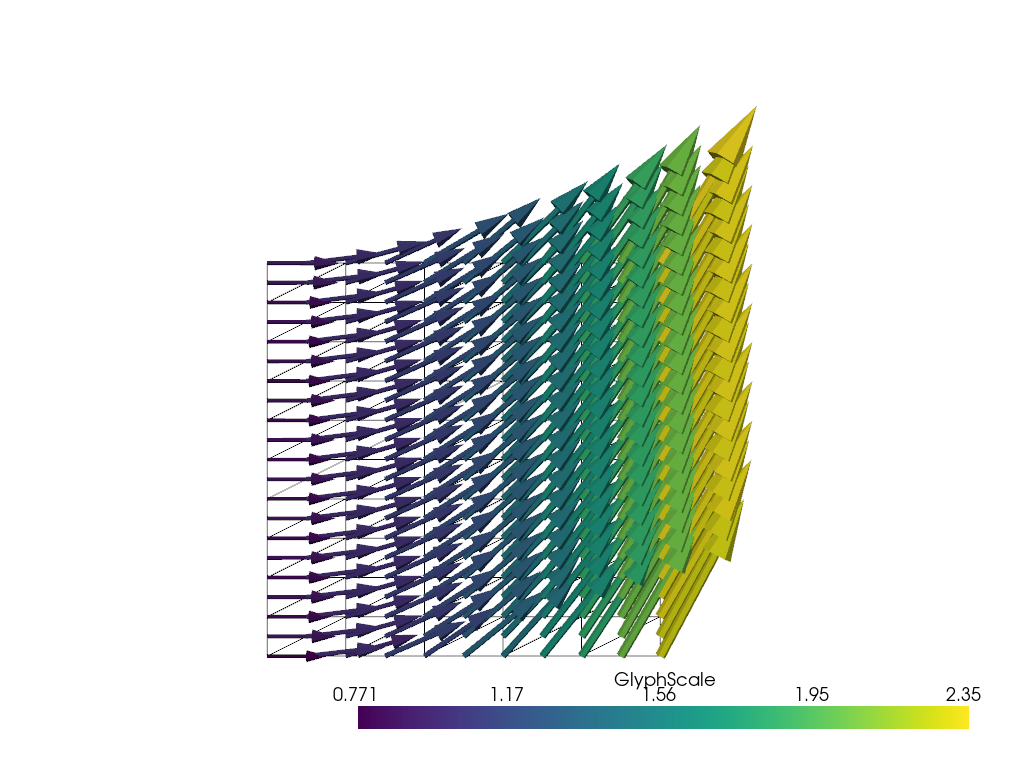

In [34]:
# *** VISUALIZATION *** #

pyvista.start_xvfb()
topology, cell_types, geometry = vtk_mesh(V)
values = np.zeros((geometry.shape[0], 3), dtype=np.float64)
values[:, :len(u_n)] = u_n.x.array.real.reshape((geometry.shape[0], len(u_n)))

# Create a point cloud of glyphs
function_grid = pyvista.UnstructuredGrid(topology, cell_types, geometry)
function_grid["u"] = values
glyphs = function_grid.glyph(orient="u", factor=0.2)

# Create a pyvista-grid for the mesh
mesh.topology.create_connectivity(mesh.topology.dim, mesh.topology.dim)
grid = pyvista.UnstructuredGrid(*vtk_mesh(mesh, mesh.topology.dim))

# Create plotter
plotter = pyvista.Plotter()
plotter.add_mesh(grid, style="wireframe", color="k")
plotter.add_mesh(glyphs)
plotter.view_xy()
if not pyvista.OFF_SCREEN:
    plotter.show()
else:
    fig_as_array = plotter.screenshot("glyphs.png")

## Mech Refinement 

This analysis will refine the mesh, an attempt to converge the solution.

The sections for the solver are combined for use, with visualization separated at the end. 

In [69]:
#Regenerate mesh

mesh = create_unit_square(MPI.COMM_WORLD, 15, 15)
t = 0 # initial time
T = 10 # total simulation time
num_steps = 500 # number of timesteps
dt = T / num_steps # calculate timestep 

## This section will execute the entirety of the solver; combined for user ease. The visualization is to be run in the next cell. 

Time 50.02, U L2-error 1.45e+00, Max U error 2.00e+00
 	 	p L2-error 2.08e+02, Max p error 4.00e+00
Time 50.42, U L2-error 1.45e+00, Max U error 2.00e+00
 	 	p L2-error 2.09e+02, Max p error 4.00e+00
Time 50.82, U L2-error 1.45e+00, Max U error 2.00e+00
 	 	p L2-error 2.09e+02, Max p error 4.00e+00
Time 51.22, U L2-error 1.45e+00, Max U error 2.00e+00
 	 	p L2-error 2.10e+02, Max p error 4.00e+00
Time 51.62, U L2-error 1.45e+00, Max U error 2.00e+00
 	 	p L2-error 2.11e+02, Max p error 4.00e+00
Time 52.02, U L2-error 1.45e+00, Max U error 2.00e+00
 	 	p L2-error 2.11e+02, Max p error 4.00e+00
Time 52.42, U L2-error 1.45e+00, Max U error 2.00e+00
 	 	p L2-error 2.12e+02, Max p error 4.00e+00
Time 52.82, U L2-error 1.45e+00, Max U error 2.00e+00
 	 	p L2-error 2.12e+02, Max p error 4.00e+00
Time 53.22, U L2-error 1.45e+00, Max U error 2.00e+00
 	 	p L2-error 2.12e+02, Max p error 4.00e+00
Time 53.62, U L2-error 1.45e+00, Max U error 2.00e+00
 	 	p L2-error 2.13e+02, Max p error 4.00e+00


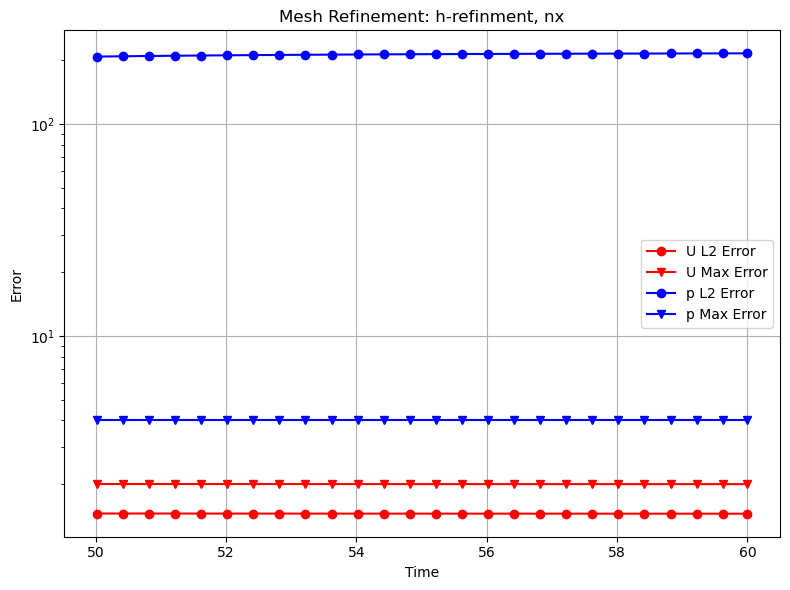

In [74]:
# Taylor Hood elements
v_cg2 = element("Lagrange", mesh.topology.cell_name(), 2, shape=(mesh.geometry.dim, )) # define piecewise quadratic elements, vector should have same dimension as the mesh
s_cg1 = element("Lagrange", mesh.topology.cell_name(), 1) # define piecewise linear elements
V = functionspace(mesh, v_cg2) # velocity function space
Q = functionspace(mesh, s_cg1) # pressure function space

# *** TRIAL FUNCTIONS *** #

u = TrialFunction(V) # trial functions for velocity
v = TestFunction(V) # admissable variations of V (velocity)
p = TrialFunction(Q) # trial functions for pressure
q = TestFunction(Q) # admissable variations of Q (pressure)

# *** DEFINE BOUNDARY CONDITIONS *** #

def topwall(x): # define where the walls are
    return np.array(np.isclose(x[0], 1))
def botwall(x): # define where the walls are
    return np.array( np.isclose(x[0], 0))

topwall_dof = locate_dofs_geometrical(V, topwall) 
u_wall = np.array((2,) * mesh.geometry.dim, dtype=PETSc.ScalarType) 
bc_wall = dirichletbc(u_wall, topwall_dof, V) 

botwall_dof = locate_dofs_geometrical(V, botwall)
u_noslip = np.array((0,) * mesh.geometry.dim, dtype=PETSc.ScalarType) 
bc_noslip = dirichletbc(u_noslip, botwall_dof, V) 



def inflow(x): # define where the inlet is
    return np.isclose(x[0], 0)

inflow_dofs = locate_dofs_geometrical(Q, inflow)
bc_inflow = dirichletbc(PETSc.ScalarType(4), inflow_dofs, Q) 



def outflow(x): # define where the outlet is
    return np.isclose(x[0], 1)

outflow_dofs = locate_dofs_geometrical(Q, outflow) 
bc_outflow = dirichletbc(PETSc.ScalarType(4), outflow_dofs, Q) 



bcu = [bc_wall, bc_noslip]
bcp = [bc_inflow, bc_outflow]


# *** DEFINE CONSTANTS/VARIABLES *** #

# Define normal vector
n = FacetNormal(mesh) 

# Define Constants
f = Constant(mesh, PETSc.ScalarType((0, 0)))
# timestep
k = Constant(mesh, PETSc.ScalarType(dt)) 
# viscosity
mu = Constant(mesh, PETSc.ScalarType(1)) 
# density
rho = Constant(mesh, PETSc.ScalarType(1)) 

# Define strain-rate tensor
def epsilon(u):
    return sym(nabla_grad(u))

# Define stress tensor
def sigma(u, p):
    return 2 * mu * epsilon(u) - p * Identity(len(u))


# *** FIRST VARIATIONAL FORM *** #

# first variational problem
u_n = Function(V)  
u_n.name = "u_n" 
U = 1* (u_n + u) 

# Define the variational problem for the first step
# <trial function, test function>

p_n = Function(Q) 
p_n.name = "p_n" 
F1 = rho * dot((u - u_n) / k, v) * dx
F1 += rho * dot(dot(u_n, nabla_grad(u_n)), v) * dx
F1 += inner(sigma(U, p_n), epsilon(v)) * dx
F1 += dot(p_n * n, v) * ds - dot(mu * nabla_grad(U) * n, v) * ds
F1 -= dot(f, v) * dx 
a1 = form(lhs(F1)) 
L1 = form(rhs(F1)) 

# assemble matrix equation : A1*U = b1
A1 = assemble_matrix(a1, bcs=bcu) 
A1.assemble()
b1 = create_vector(L1) 

# *** SECOND VARIATIONAL FORM *** #

# Define variational problem for step 2
u_ = Function(V) 
a2 = form(dot(nabla_grad(p), nabla_grad(q)) * dx) 
L2 = form(dot(nabla_grad(p_n), nabla_grad(q)) * dx - (rho / k) * div(u_) * q * dx) 
A2 = assemble_matrix(a2, bcs=bcp) 
A2.assemble()
b2 = create_vector(L2) 

# *** THIRD VARIATIONAL FORM *** #

# Define variational problem for step 3
p_ = Function(Q) 
a3 = form(rho * dot(u, v) * dx) 
L3 = form(rho * dot(u_, v) * dx - k * dot(nabla_grad(p_ - p_n), v) * dx) 
A3 = assemble_matrix(a3) 
A3.assemble() 
b3 = create_vector(L3) 

# *** SOLVER OPTIONS FOR EACH STEP *** #

# Solver for step 1
solver1 = PETSc.KSP().create(mesh.comm) 
solver1.setOperators(A1) 
solver1.setType(PETSc.KSP.Type.BCGS) 
pc1 = solver1.getPC() 
pc1.setType(PETSc.PC.Type.HYPRE) 
pc1.setHYPREType("boomeramg") 

# Solver for step 2
solver2 = PETSc.KSP().create(mesh.comm) 
solver2.setOperators(A2) 
solver2.setType(PETSc.KSP.Type.BCGS) 
pc2 = solver2.getPC() 
pc2.setType(PETSc.PC.Type.HYPRE) 
pc2.setHYPREType("boomeramg") 

# Solver for step 3
solver3 = PETSc.KSP().create(mesh.comm) 
solver3.setOperators(A3) 
solver3.setType(PETSc.KSP.Type.CG) 
pc3 = solver3.getPC() 
pc3.setType(PETSc.PC.Type.SOR) 



from pathlib import Path 
folder = Path("results") 
folder.mkdir(exist_ok=True, parents=True) 
vtx_u = VTXWriter(mesh.comm, folder / "couette_u.bp", u_n, engine="BP4")  
vtx_p = VTXWriter(mesh.comm, folder / "couette_p.bp", p_n, engine="BP4")
vtx_u.write(t)
vtx_p.write(t) 

# *** LOOP OVER TIME TO SOLVE *** #

for i in range(num_steps):
    # Update current time step
    t += dt

    # Step 1: Tentative veolcity step
    with b1.localForm() as loc_1:
        loc_1.set(0)
    assemble_vector(b1, L1)
    apply_lifting(b1, [a1], [bcu]) 
    b1.ghostUpdate(addv=PETSc.InsertMode.ADD_VALUES, mode=PETSc.ScatterMode.REVERSE) 
    set_bc(b1, bcu)
    solver1.solve(b1, u_.x.petsc_vec) 
    u_.x.scatter_forward() 

    # Step 2: Pressure corrrection step
    with b2.localForm() as loc_2:
        loc_2.set(0)
    assemble_vector(b2, L2) 
    apply_lifting(b2, [a2], [bcp]) 
    b2.ghostUpdate(addv=PETSc.InsertMode.ADD_VALUES, mode=PETSc.ScatterMode.REVERSE) 
    set_bc(b2, bcp) 
    solver2.solve(b2, p_.x.petsc_vec) 
    p_.x.scatter_forward() 

    # Step 3: Velocity correction step
    with b3.localForm() as loc_3:
        loc_3.set(0)
    assemble_vector(b3, L3) 
    b3.ghostUpdate(addv=PETSc.InsertMode.ADD_VALUES, mode=PETSc.ScatterMode.REVERSE) 
    solver3.solve(b3, u_.x.petsc_vec) 
    u_.x.scatter_forward() 
    u_n.x.array[:] = u_.x.array[:]
    p_n.x.array[:] = p_.x.array[:]


# *** OUTPUT FILES *** #

import matplotlib.pyplot as plt
from pathlib import Path # for navigation
folder = Path("results") # define output directory as pwd/results
folder.mkdir(exist_ok=True, parents=True) # make the output directory and any recursive directories
vtx_u = VTXWriter(mesh.comm, folder / "poiseuille_u.bp", u_n, engine="BP4") # make vtx file for velocity 
vtx_p = VTXWriter(mesh.comm, folder / "poiseuille_p.bp", p_n, engine="BP4") # make vtx file for pressure
vtx_u.write(t) # write time to velocity file
vtx_p.write(t) # write time to pressure file

# ** ANALYTIC SOLUTION *** #

def u_exact(x): # analytic solution function
    values = np.zeros((2, x.shape[1]), dtype=PETSc.ScalarType) 
    values[0] = 4 * x[2] 
    return values

def p_exact(x):
    values_p = np.zeros((1,x.shape[1]),dtype=PETSc.ScalarType)
    values_p[0] = 8 * (1 - x[0])
    return values_p


u_ex = Function(V) # exact solution is in the velocity function space
u_ex.interpolate(u_exact) # solve analytic solution

p_ex = Function(Q)
p_ex.interpolate(p_exact)

L2_error = form(dot(u_ - u_ex, u_ - u_ex) * dx) # find error between fenics and analytic
L2_error_p = form(dot(p_ - p_ex, p_ - p_ex) * dx)
# *** LOOP OVER TIME TO SOLVE *** #

time = []
L2errU = []
maxErrU = []
L2errp = []
maxErrp = []

for i in range(num_steps):
    # Update current time step
    t += dt

    # Step 1: Tentative veolcity step
    with b1.localForm() as loc_1:
        loc_1.set(0)
    assemble_vector(b1, L1) # rhs of eq 39 is stored in b1 as a vector
    apply_lifting(b1, [a1], [bcu]) # apply BC to the coefficient matrix
    b1.ghostUpdate(addv=PETSc.InsertMode.ADD_VALUES, mode=PETSc.ScatterMode.REVERSE) # sync for parallel processing
    set_bc(b1, bcu) # set BC on the rhs
    solver1.solve(b1, u_.x.petsc_vec) # solve A1 * u* = b1 based on set schemes
    u_.x.scatter_forward() # sync for parallel processing

    # Step 2: Pressure corrrection step
    with b2.localForm() as loc_2:
        loc_2.set(0)
    assemble_vector(b2, L2) # rhs of eq. 40 is stored in b2
    apply_lifting(b2, [a2], [bcp]) # apply BC to the coefficient matrix
    b2.ghostUpdate(addv=PETSc.InsertMode.ADD_VALUES, mode=PETSc.ScatterMode.REVERSE) # sync for parallel processing
    set_bc(b2, bcp) # set the BC
    solver2.solve(b2, p_.x.petsc_vec) # solve A2*p = b2 based on set schemes
    p_.x.scatter_forward() # sync for parallel processing

    # Step 3: Velocity correction step
    with b3.localForm() as loc_3:
        loc_3.set(0)
    assemble_vector(b3, L3) # rhs of eq. 42 stored in b3
    b3.ghostUpdate(addv=PETSc.InsertMode.ADD_VALUES, mode=PETSc.ScatterMode.REVERSE) # sync for parallel processing
    solver3.solve(b3, u_.x.petsc_vec) # solve A3 * u = b3 based on set schemes
    u_.x.scatter_forward() # sync for parallel processing
    # Update variable with solution form this time step
    u_n.x.array[:] = u_.x.array[:]
    p_n.x.array[:] = p_.x.array[:]

    # Write solutions to file
    vtx_u.write(t)
    vtx_p.write(t)

    # Compute error at current time-step
    error_L2 = np.sqrt(mesh.comm.allreduce(assemble_scalar(L2_error), op=MPI.SUM))
    error_max = mesh.comm.allreduce(np.max(u_.x.petsc_vec.array - u_ex.x.petsc_vec.array), op=MPI.MAX)

    error_L2p = np.sqrt(mesh.comm.allreduce(assemble_scalar(L2_error_p), op=MPI.SUM))
    error_maxp = mesh.comm.allreduce(np.max(p_.x.petsc_vec.array - p_ex.x.petsc_vec.array), op=MPI.MAX)
    # Print error only every 20th step and at the last step

    if (i % 20 == 0) or (i == num_steps - 1):
        time.append(t)
        L2errU.append(error_L2)
        maxErrU.append(error_max)
        L2errp.append(error_L2p)
        maxErrp.append(error_maxp)
        #print(f"Time {t:.2f}, L2-error {error_L2:.2e}, Max error {error_max:.2e}")
        print(f"Time {t:.2f}, U L2-error {error_L2:.2e}, Max U error {error_max:.2e}\n \t \tp L2-error {error_L2p:.2e}, Max p error {error_maxp:.2e}")

# Close xmdf files
vtx_u.close()
vtx_p.close()
# detroy the solvers and the vectors
b1.destroy()
b2.destroy()
b3.destroy()
solver1.destroy()
solver2.destroy()
solver3.destroy()

%matplotlib inline
plt.figure(figsize=(8, 6))
plt.semilogy(time, L2errU, 'ro-', time, maxErrU, 'rv-',time, L2errp, 'bo-', time, maxErrp, 'bv-')
#plt.semilogx(q_loop, all_w_analytic, 'b--', label="Analytical w")
plt.xlabel("Time")
plt.ylabel("Error")
plt.title("Mesh Refinement: h-refinment, nx")
plt.legend(("U L2 Error", "U Max Error", "p L2 Error", "p Max Error"))
plt.grid(True)
plt.tight_layout()

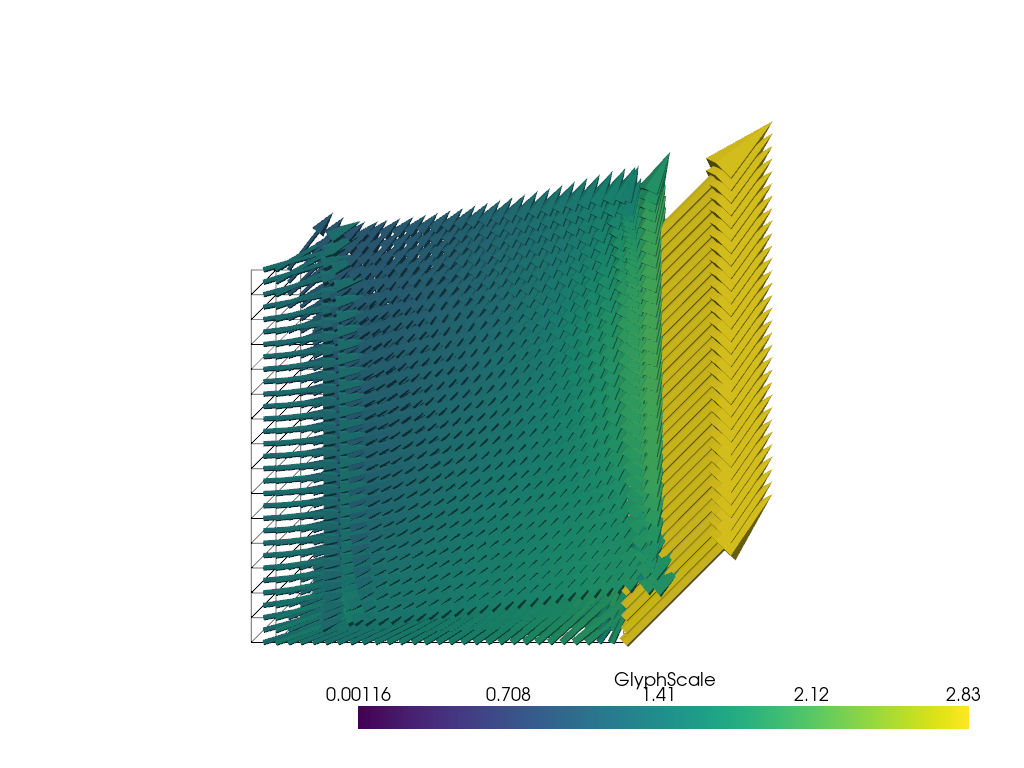

In [75]:
# *** VISUALIZATION *** #

pyvista.start_xvfb()
topology, cell_types, geometry = vtk_mesh(V)
values = np.zeros((geometry.shape[0], 3), dtype=np.float64)
values[:, :len(u_n)] = u_n.x.array.real.reshape((geometry.shape[0], len(u_n)))

# Create a point cloud of glyphs
function_grid = pyvista.UnstructuredGrid(topology, cell_types, geometry)
function_grid["u"] = values
glyphs = function_grid.glyph(orient="u", factor=0.2)

# Create a pyvista-grid for the mesh
mesh.topology.create_connectivity(mesh.topology.dim, mesh.topology.dim)
grid = pyvista.UnstructuredGrid(*vtk_mesh(mesh, mesh.topology.dim))

# Create plotter
plotter = pyvista.Plotter()
plotter.add_mesh(grid, style="wireframe", color="k")
plotter.add_mesh(glyphs)
plotter.view_xy()
if not pyvista.OFF_SCREEN:
    plotter.show()
else:
    fig_as_array = plotter.screenshot("glyphs.png")

## Failed Solver

This example only evaluates the solver, as the setup is expected to fail based on the inputs provided. 

The issue here will be the initial velocity guess will be set to zero, the result is evidently incorrect. 

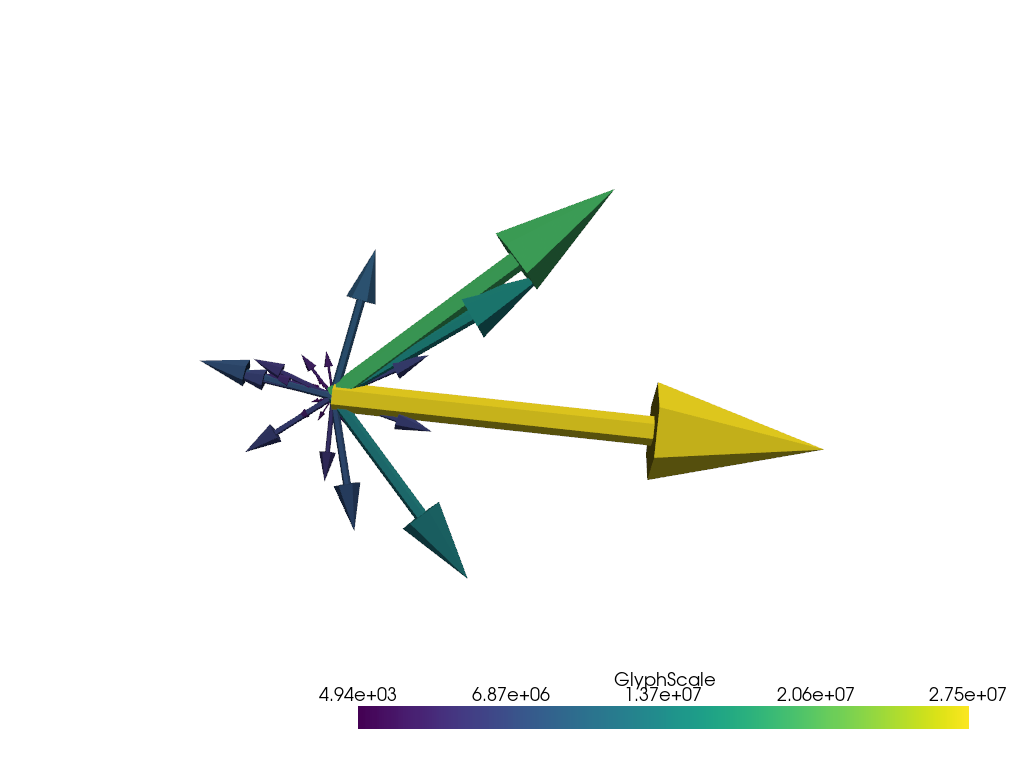

In [38]:
#Regenerate mesh

mesh = create_unit_square(MPI.COMM_WORLD, 10, 10) # create 10x10 element square
t = 0 # initial time
T = 1 # total simulation time
num_steps = 4 # number of timesteps
dt = T / num_steps # calculate timestep 


# Taylor Hood elements
v_cg2 = element("Lagrange", mesh.topology.cell_name(), 2, shape=(mesh.geometry.dim, )) # define piecewise quadratic elements, vector should have same dimension as the mesh
s_cg1 = element("Lagrange", mesh.topology.cell_name(), 1) # define piecewise linear elements
V = functionspace(mesh, v_cg2) # velocity function space
Q = functionspace(mesh, s_cg1) # pressure function space

# *** TRIAL FUNCTIONS *** #

u = TrialFunction(V) # trial functions for velocity
v = TestFunction(V) # admissable variations of V (velocity)
p = TrialFunction(Q) # trial functions for pressure
q = TestFunction(Q) # admissable variations of Q (pressure)

# *** DEFINE BOUNDARY CONDITIONS *** #

def topwall(x): # define where the walls are
    return np.array(np.isclose(x[1], 0))
def botwall(x): # define where the walls are
    return np.array( np.isclose(x[0], 0))

topwall_dof = locate_dofs_geometrical(V, topwall) 
u_wall = np.array((2,) * mesh.geometry.dim, dtype=PETSc.ScalarType) 
bc_wall = dirichletbc(u_wall, topwall_dof, V) 

botwall_dof = locate_dofs_geometrical(V, botwall) 
u_noslip = np.array((0,) * mesh.geometry.dim, dtype=PETSc.ScalarType) 
bc_noslip = dirichletbc(u_noslip, botwall_dof, V) 



def inflow(x): # define where the inlet is
    return np.isclose(x[0], 0)

inflow_dofs = locate_dofs_geometrical(Q, inflow) 
bc_inflow = dirichletbc(PETSc.ScalarType(0), inflow_dofs, Q) 



def outflow(x): # define where the outlet is
    return np.isclose(x[0], 1)

outflow_dofs = locate_dofs_geometrical(Q, outflow)
bc_outflow = dirichletbc(PETSc.ScalarType(0), outflow_dofs, Q) 



bcu = [bc_wall, bc_noslip]
bcp = [bc_inflow, bc_outflow]


# *** DEFINE CONSTANTS/VARIABLES *** #

# Define normal vector
n = FacetNormal(mesh) 

# Define Constants
 # additional body forces (none are included for couette flow)
f = Constant(mesh, PETSc.ScalarType((0, 0)))
# timestep
k = Constant(mesh, PETSc.ScalarType(dt)) 
# viscosity
mu = Constant(mesh, PETSc.ScalarType(1)) 
# density
rho = Constant(mesh, PETSc.ScalarType(1)) 

# Define strain-rate tensor
def epsilon(u):
    return sym(nabla_grad(u))

# Define stress tensor
def sigma(u, p):
    return 2 * mu * epsilon(u) - p * Identity(len(u))


# *** FIRST VARIATIONAL FORM *** #

# first variational problem
u_n = Function(V)  
u_n.name = "u_n" 
U = 1* (u_n *0.01) 

# Define the variational problem for the first step
# <trial function, test function>

p_n = Function(Q) 
p_n.name = "p_n" 
F1 = rho * dot((u - u_n) / k, v) * dx
F1 += rho * dot(dot(u_n, nabla_grad(u_n)), v) * dx
F1 += inner(sigma(U, p_n), epsilon(v)) * dx
F1 += dot(p_n * n, v) * ds - dot(mu * nabla_grad(U) * n, v) * ds
F1 -= dot(f, v) * dx 
a1 = form(lhs(F1)) 
L1 = form(rhs(F1)) 

# assemble matrix equation : A1*U = b1
A1 = assemble_matrix(a1, bcs=bcu) 
A1.assemble()
b1 = create_vector(L1) 

# *** SECOND VARIATIONAL FORM *** #

# Define variational problem for step 2
u_ = Function(V) 
a2 = form(dot(nabla_grad(p), nabla_grad(q)) * dx) 
L2 = form(dot(nabla_grad(p_n), nabla_grad(q)) * dx - (rho / k) * div(u_) * q * dx) 
A2 = assemble_matrix(a2, bcs=bcp) 
A2.assemble()
b2 = create_vector(L2) 

# *** THIRD VARIATIONAL FORM *** #

# Define variational problem for step 3
p_ = Function(Q) 
a3 = form(rho * dot(u, v) * dx) 
L3 = form(rho * dot(u_, v) * dx - k * dot(nabla_grad(p_ - p_n), v) * dx) 
A3 = assemble_matrix(a3) 
A3.assemble() 
b3 = create_vector(L3) 

# *** SOLVER OPTIONS FOR EACH STEP *** #

# Solver for step 1
solver1 = PETSc.KSP().create(mesh.comm) 
solver1.setOperators(A1) 
solver1.setType(PETSc.KSP.Type.BCGS) 
pc1 = solver1.getPC() 
pc1.setType(PETSc.PC.Type.HYPRE) 
pc1.setHYPREType("boomeramg") 

# Solver for step 2
solver2 = PETSc.KSP().create(mesh.comm) 
solver2.setOperators(A2) 
solver2.setType(PETSc.KSP.Type.BCGS) 
pc2 = solver2.getPC() 
pc2.setType(PETSc.PC.Type.HYPRE) 
pc2.setHYPREType("boomeramg") 

# Solver for step 3
solver3 = PETSc.KSP().create(mesh.comm) 
solver3.setOperators(A3) 
solver3.setType(PETSc.KSP.Type.CG) 
pc3 = solver3.getPC() 
pc3.setType(PETSc.PC.Type.SOR) 



from pathlib import Path 
folder = Path("results") 
folder.mkdir(exist_ok=True, parents=True) 
vtx_u = VTXWriter(mesh.comm, folder / "couette_u.bp", u_n, engine="BP4")  
vtx_p = VTXWriter(mesh.comm, folder / "couette_p.bp", p_n, engine="BP4")
vtx_u.write(t)
vtx_p.write(t) 

# *** LOOP OVER TIME TO SOLVE *** #

for i in range(num_steps):
    # Update current time step
    t += dt

    # Step 1: Tentative veolcity step
    with b1.localForm() as loc_1:
        loc_1.set(0)
    assemble_vector(b1, L1)
    apply_lifting(b1, [a1], [bcu]) 
    b1.ghostUpdate(addv=PETSc.InsertMode.ADD_VALUES, mode=PETSc.ScatterMode.REVERSE) 
    set_bc(b1, bcu)
    solver1.solve(b1, u_.x.petsc_vec) 
    u_.x.scatter_forward() 

    # Step 2: Pressure corrrection step
    with b2.localForm() as loc_2:
        loc_2.set(0)
    assemble_vector(b2, L2) 
    apply_lifting(b2, [a2], [bcp]) 
    b2.ghostUpdate(addv=PETSc.InsertMode.ADD_VALUES, mode=PETSc.ScatterMode.REVERSE) 
    set_bc(b2, bcp) 
    solver2.solve(b2, p_.x.petsc_vec) 
    p_.x.scatter_forward() 

    # Step 3: Velocity correction step
    with b3.localForm() as loc_3:
        loc_3.set(0)
    assemble_vector(b3, L3) 
    b3.ghostUpdate(addv=PETSc.InsertMode.ADD_VALUES, mode=PETSc.ScatterMode.REVERSE) 
    solver3.solve(b3, u_.x.petsc_vec) 
    u_.x.scatter_forward() 
    u_n.x.array[:] = u_.x.array[:]
    p_n.x.array[:] = p_.x.array[:]

# *** VISUALIZATION *** #

pyvista.start_xvfb()
topology, cell_types, geometry = vtk_mesh(V)
values = np.zeros((geometry.shape[0], 3), dtype=np.float64)
values[:, :len(u_n)] = u_n.x.array.real.reshape((geometry.shape[0], len(u_n)))

# Create a point cloud of glyphs
function_grid = pyvista.UnstructuredGrid(topology, cell_types, geometry)
function_grid["u"] = values
glyphs = function_grid.glyph(orient="u", factor=0.2)

# Create a pyvista-grid for the mesh
mesh.topology.create_connectivity(mesh.topology.dim, mesh.topology.dim)
grid = pyvista.UnstructuredGrid(*vtk_mesh(mesh, mesh.topology.dim))

# Create plotter
plotter = pyvista.Plotter()
plotter.add_mesh(grid, style="wireframe", color="k")
plotter.add_mesh(glyphs)
plotter.view_xy()
if not pyvista.OFF_SCREEN:
    plotter.show()
else:
    fig_as_array = plotter.screenshot("glyphs.png")